In [1]:
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable


# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The output can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [2]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


Download the dataset

In [3]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/Users/alessiopittiglio/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8)
corpus = ['<start> ' + row['generic_sentence'].replace(",", " <comma>") + ' <end>' for row in ds]
corpus = np.array(corpus)

Create a tokenizer and Detokenizer

In [5]:
tokenizer = TextVectorization(max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) # con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s = "<start>"
          elif t == 2:
            s = "<end>"
          elif t == 7:
            s = "<comma>"
          else:
            s = self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

detokenizer = TextDetokenizer(tokenizer)
sentences = tokenizer(corpus).numpy()

2024-06-18 22:01:10.751882: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-18 22:01:10.751942: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-18 22:01:10.751963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-18 22:01:10.752158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 22:01:10.752170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum((sentences == 1), axis=1) >= 1
original_data = np.delete(sentences, mask, axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data_batch = np.array([self.data[k] for k in indexes])

        # copy of ordered sequences
        result = np.copy(data_batch)

        # shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i, 1:data_batch[i].argmin() - 1])

        return data_batch, result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# make a random permutation of training and test set
np.random.seed(42)
# shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
# split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
x, y = test_generator.__getitem__(1)

x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>
shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>


original:  <start> some earwigs have stripes on the thorax and abdomen <end>
shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>


original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>
shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>


original:  <start> healthy wetlands means cleaner water <comma> reduced flooding and more places for recreation <end>
shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>


original:  <start> market share is the percent share in sales one company controls in a particular market <end>
shuffled:  <start> company percent share one controls a sales in market is

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [12]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  # print(match.size)
  return (match.size / max(len(p), len(s)))

Let's do an example.

In [13]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# My solution

Before approaching this task, I conducted an in-depth literature review to understand the state-of-the-art (SOTA) methods for solving sentence reconstruction problems. I explored various techniques and models. After analyzing various options and considering the limitations and suggestions from the literature.

First, I import the required libraries for building and training my Transformer model using Keras. These libraries include:

In [14]:
import keras
import keras.ops as ops
import random
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

I define `MyDataGenerator` class to generate batches of data for training the Transformer model:

In [15]:
class MyDataGenerator(Sequence):
    def __init__(self, data, batch_size=64, shuffle=True, seed=42, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        np.random.seed(self.seed)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data_batch = np.array([self.data[k] for k in indexes])

        decoder_outputs = np.zeros_like(data_batch)
        decoder_outputs[:, :-1] = data_batch[:, 1:]

        decoder_inputs = np.copy(data_batch)
        padding_start = np.argmax(decoder_inputs == 0, axis=1)
        row_indices = np.arange(decoder_inputs.shape[0])
        decoder_inputs[row_indices, padding_start - 1] = 0

        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i, 1:data_batch[i].argmin() - 1])

        encoder_inputs = np.copy(data_batch)

        return (encoder_inputs, decoder_inputs), decoder_outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

I divide the dataset into three parts: training, validation, and test sets.

In [16]:
train_size = 200000
val_size = 20000
test_size = len(original_data) - train_size - val_size
batch_size = 64

# make a random permutation of training and test set
np.random.seed(42)

# shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

train_data = shuffled_data[:train_size]
val_data = shuffled_data[train_size:train_size + val_size]
test_data = shuffled_data[train_size + val_size:]

train_generator = MyDataGenerator(train_data, batch_size=batch_size)
val_generator = MyDataGenerator(val_data, batch_size=batch_size, shuffle=False)
test_generator = MyDataGenerator(test_data, batch_size=batch_size, shuffle=False)

In [17]:
inputs, targets = test_generator.__getitem__(1)

encoder_inputs, decoder_inputs = inputs

print(encoder_inputs.shape)
print(decoder_inputs.shape)
print(targets.shape)

(64, 28)
(64, 28)
(64, 28)


Check the data by detokenizing and printing some examples to compare the original, shuffled, and target sentences.

In [18]:
encoder_inputs = detokenizer(inputs[0])
decoder_inputs = detokenizer(inputs[1])
decoder_outputs = detokenizer(targets)

for i in range(3):
    print("encoder inputs: ", encoder_inputs[i])
    print("decoder inputs: ", decoder_inputs[i])
    print("decoder outputs: ", decoder_outputs[i])
    print("\n")

encoder inputs:  <start> the most their teens have women in for time sex first <end>
decoder inputs:  <start> most women have sex for the first time in their teens
decoder outputs:  most women have sex for the first time in their teens <end>


encoder inputs:  <start> psychology corner health is care a much the system larger than of <end>
decoder inputs:  <start> psychology is much larger than a corner of the health care system
decoder outputs:  psychology is much larger than a corner of the health care system <end>


encoder inputs:  <start> of in and the states killer remains united both one men heart number women disease <end>
decoder inputs:  <start> heart disease remains the number one killer of both men and women in united states
decoder outputs:  heart disease remains the number one killer of both men and women in united states <end>




My sequence-to-sequence Transformer consists of a `TransformerEncoder` and a `TransformerDecoder` chained together. The source sequence is passed to the `TransformerEncoder` to produce a new representation, which is then passed to the `TransformerDecoder` along with the target sequence so far. The `TransformerDecoder` predicts the next words in the target sequence using causal masking to ensure only past and present tokens are considered.

In [19]:
num_layers = 6
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.1
sequence_length = max([len(x) for x in original_data])

def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        x = self.embedding(x)
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        return x

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )

        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.token_embedding = TokenEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.token_embedding(x)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=10000,
    dropout_rate=dropout_rate)

transformer((inputs[0], inputs[1]))

transformer.summary()

/Users/alessiopittiglio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/alessiopittiglio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/alessiopittiglio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layer

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │    18,340,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │    30,965,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,876,112 (197.89 MB)

 Trainable params: 51,876,112 (197.89 MB)

 Non-trainable params: 0 (0.00 B)

Next, I assemble the end-to-end Transformer model by defining the shared embedding layer, encoder, and decoder, and chaining them together.

Finally, let's demonstrate how to reorder new English sentences. I simply feed into the model the vectorized English sentence as well as the target token `<start>`, then I repeatedly generated the next token, until I hit the token `<end>`.

In [20]:
def decode_sequences(input_sequences):
    input_sequences = tf.convert_to_tensor(input_sequences, dtype=tf.int32)
    batch_size = input_sequences.shape[0]

    decoded_sentences = ["<start>"] * batch_size
    decoded_sentences_list = [["<start>"] for _ in range(batch_size)]

    for i in range(sequence_length):
        tokenized_sentences = tokenizer(decoded_sentences)
        padded_tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=sequence_length, padding='post')
        padded_tokenized_sentences = tf.convert_to_tensor(padded_tokenized_sentences, dtype=tf.int32)

        predictions = transformer([input_sequences, padded_tokenized_sentences])

        sampled_token_indices = ops.convert_to_numpy(
            ops.argmax(predictions[:, i, :], axis=1)
        )

        sampled_tokens = [detokenizer([[idx]])[0] for idx in sampled_token_indices]

        for j, token in enumerate(sampled_tokens):
            if token == "<end>":
                decoded_sentences[j] += " " + token
                decoded_sentences_list[j].append(token)
                break
            else:
                decoded_sentences[j] += " " + token
                decoded_sentences_list[j].append(token)

    return [" ".join(tokens) for tokens in decoded_sentences_list]

I create a custom callback, `ScoreCallback`, to evaluate the model's performance on samples from both the training and validation sets at the end of each epoch, saving the best model weights and keeping track of scores.

In [22]:
class ScoreCallback(Callback):
    def __init__(self, train_generator, val_generator, detokenizer, decode_sequences, score_function, sample_size=10, filepath='best_model_epoch_{epoch:02d}.weights.h5'):
        super(ScoreCallback, self).__init__()
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.detokenizer = detokenizer
        self.decode_sequences = decode_sequences
        self.score_function = score_function
        self.sample_size = sample_size
        self.filepath = filepath
        self.best_score = -np.Inf
        self.train_scores = []
        self.val_scores = []

    def on_epoch_end(self, epoch, logs=None):
        train_scores = self.compute_scores(self.train_generator)
        val_scores = self.compute_scores(self.val_generator)

        average_train_score = np.mean(train_scores)
        average_val_score = np.mean(val_scores)

        self.train_scores.append(average_train_score)
        self.val_scores.append(average_val_score)

        if logs is not None:
            logs['average_train_score'] = average_train_score
            logs['average_val_score'] = average_val_score

        if average_val_score > self.best_score:
            self.best_score = average_val_score
            filepath_with_epoch = self.filepath.format(epoch=epoch + 1)
            self.model.save_weights(filepath_with_epoch)

    def compute_scores(self, generator):
        all_scores = []
        num_batches = len(generator)
        total_samples = 0

        for batch_index in range(num_batches):
            x, y = generator.__getitem__(batch_index)
            batch_size = x[0].shape[0]
            total_samples += batch_size

            shuffled_sentences = self.detokenizer(x[0])
            original_sentences = self.detokenizer(x[1])
            reordered_sentences = self.decode_sequences(x[0])

            for original, reordered in zip(original_sentences, reordered_sentences):
                original = original.replace("<start>", "").replace("<end>", "").strip()
                reordered = reordered.replace("<start>", "").replace("<end>", "").strip()
                s = self.score_function(original[1:-1], reordered[1:-1])
                all_scores.append(s)

            if total_samples >= self.sample_size:
                break

        return all_scores

score_callback = ScoreCallback(
    train_generator=train_generator,
    val_generator=test_generator,
    detokenizer=detokenizer,
    decode_sequences=decode_sequences,
    score_function=score,
    sample_size=50,
    filepath='best_model_epoch_{epoch:02d}.weights.h5'
)

I set up a learning rate scheduler to reduce the learning rate by a factor of 0.2 if the validation loss does not improve for 2 consecutive epochs, and initialized the RMSprop optimizer with an initial learning rate of 0.001.

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

restart_scheduler = keras.optimizers.schedules.CosineDecayRestarts(8e-04,3e04,t_mul=0.5,m_mul=0.01

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

I compile and train the model for 30 epochs, using `Adam` as the optimizer and `sparse_categorical_crossentropy` as the loss function, while monitoring the performance with `masked_accuracy` and employing custom callbacks for learning rate reduction and score evaluation.

In [24]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [25]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [26]:
epochs = 30

transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

transformer.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[score_callback])

Epoch 1/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 204s 178ms/step - loss: 8.0463 - masked_accuracy: 0.1437 - val_loss: 4.4201 - val_masked_accuracy: 0.4167 - average_train_score: 0.1035 - average_val_score: 0.1183
Epoch 2/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - loss: 3.7768 - masked_accuracy: 0.4822 - val_loss: 2.1767 - val_masked_accuracy: 0.6412 - average_train_score: 0.3026 - average_val_score: 0.2878
Epoch 3/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - loss: 1.8937 - masked_accuracy: 0.6632 - val_loss: 1.3118 - val_masked_accuracy: 0.7209 - average_train_score: 0.3630 - average_val_score: 0.3341
Epoch 4/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - loss: 1.1514 - masked_accuracy: 0.7383 - val_loss: 1.0806 - val_masked_accuracy: 0.7468 - average_train_score: 0.4007 - average_val_score: 0.3747
Epoch 5/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - loss: 0.9062 - masked_accuracy: 0.7702 - val_loss: 0.9965 - val_masked_accuracy: 0.7577 - average_train_score: 0.3938 - averag

I visualize the training and validation scores over epochs using a line plot, where the x-axis represents the epochs and the y-axis represents the scores

In [ ]:
transformer.load_weights('best_model_epoch_21.weights.h5')

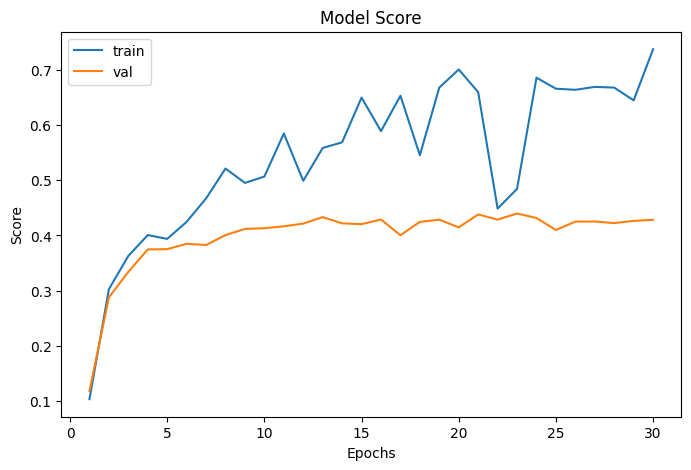

In [27]:
plt.figure(figsize=(8, 5))
actual_epochs = len(score_callback.train_scores)
plt.plot(range(1, actual_epochs + 1), score_callback.train_scores, label='train')
plt.plot(range(1, actual_epochs + 1), score_callback.val_scores, label='val')
plt.title('Model Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

I select and print a few random samples from the test set to compare the original, shuffled, and reordered sentences, evaluating the model's performance qualitatively.

In [28]:
def decode_sequence(input_sequence):
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.int32)
    input_sequence = tf.expand_dims(input_sequence, axis=0)

    decoded_sentence = "<start>"
    for i in range(sequence_length):
        tokenized_sentence = tokenizer([decoded_sentence])
        padded_tokenized_sentence = pad_sequences(tokenized_sentence, maxlen=sequence_length, padding='post')
        padded_tokenized_sentence = tf.convert_to_tensor(padded_tokenized_sentence, dtype=tf.int32)

        predictions = transformer([input_sequence, padded_tokenized_sentence])

        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = detokenizer([[sampled_token_index]])[0]


        decoded_sentence += " " + sampled_token
        if sampled_token == "<end>":
          break

    return decoded_sentence

for _ in range(3):
    idx = random.choice(range(len(test_generator)))
    x, y = test_generator.__getitem__(idx)

    batch_size = x[0].shape[0]
    sentence_idx = random.choice(range(batch_size))
    shuffled_input = x[0][sentence_idx]

    shuffled_sentence = detokenizer(x[0])[sentence_idx]
    original_sentence = detokenizer(x[1])[sentence_idx]
    reordered_sentence = decode_sequence(shuffled_input)

    print(f"Original: {original_sentence}")
    print(f"Shuffled: {shuffled_sentence}")
    print(f"Reordered: {reordered_sentence}\n")

Original: <start> advertising is most prominent in a free market economy
Shuffled: <start> in market prominent a economy is free advertising most <end>
Reordered: <start> advertising is most prominent in a free market economy <end>

Original: <start> nuclear power is in decline in the united states
Shuffled: <start> united nuclear in in power the states decline is <end>
Reordered: <start> nuclear power is in decline in the united states <end>

Original: <start> gender is a significant factor in our every day lives
Shuffled: <start> a is our significant day factor lives every in gender <end>
Reordered: <start> gender is a significant factor in our every day lives <end>



I also test the reordering functionality on a specific example sentence to verify the model's ability to correctly reconstruct scrambled sentences.

In [29]:
scrambled_sentence = "paper dried dirt has easier to is remove after"
original_sentence = "dirt is easier to remove after paper has dried"

tokenized_scrambled_sentence = tokenizer([scrambled_sentence])
padded_tokenized_scrambled_sentence = pad_sequences(tokenized_scrambled_sentence, maxlen=sequence_length, padding='post')
reordered_sentence = decode_sequence(padded_tokenized_scrambled_sentence[0])

print(f"Scrambled: {scrambled_sentence}")
print(f"Reordered: {reordered_sentence}\n")

Scrambled: paper dried dirt has easier to is remove after
Reordered: <start> dried paper has to remove is easier after <end>



I evaluate the model's performance on a sample of the test set by computing the average score for 3000 samples.

In [30]:
all_scores = []
num_batches = len(test_generator)
total_samples = 0

for batch_index in range(num_batches):
    x, y = test_generator.__getitem__(batch_index)
    batch_size = x[0].shape[0]
    total_samples += batch_size

    shuffled_sentences = detokenizer(x[0])
    original_sentences = detokenizer(x[1])
    reordered_sentences = decode_sequences(x[0])

    for original, reordered in zip(original_sentences, reordered_sentences):
        original = original.replace("<start>", "").replace("<end>", "").strip()
        reordered = reordered.replace("<start>", "").replace("<end>", "").strip()
        s = score(original, reordered)

        all_scores.append(s)

    if total_samples >= 3000:
        break

average_score = np.mean(all_scores)
print(f"Average score: {average_score:.4f}")

Average score: 0.4423


I visualize the distribution of scores using a histogram, where the x-axis represents the scores and the y-axis represents their frequency

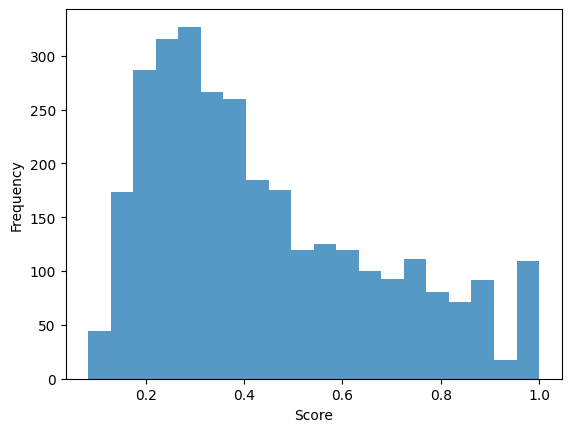

In [31]:
plt.figure()
plt.hist(all_scores, bins=20, alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()